In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

1. Inspect the transaction data

In [2]:
transaction = pd.read_excel('QVI_transaction_data.xlsx')

Check if there is any empty value in the given table

In [3]:
rows_with_empty1 = transaction.isna().any(axis=1)
rows_with_empty1 = transaction[rows_with_empty1]  # only keep rows contanining empty value
print(rows_with_empty1.shape)

(0, 8)


Also, do the format checkup

In [4]:
transaction.dtypes

DATE                int64
STORE_NBR           int64
LYLTY_CARD_NBR      int64
TXN_ID              int64
PROD_NBR            int64
PROD_NAME          object
PROD_QTY            int64
TOT_SALES         float64
dtype: object

In [5]:
def is_uniform_format(column_name, datatype):
    # return True if formats do not match
    rows_different_type = ~transaction[column_name].apply(lambda x: isinstance(x, datatype))  
    return rows_different_type.sum() == 0  # sum up all boolean values, if the sum is 0 then all boolean values are False

In [6]:
print(is_uniform_format('DATE', int))
print(is_uniform_format('STORE_NBR', int))
print(is_uniform_format('LYLTY_CARD_NBR', int))
print(is_uniform_format('TXN_ID', int))
print(is_uniform_format('PROD_NBR', int))
print(is_uniform_format('PROD_NAME', object))
print(is_uniform_format('PROD_QTY', int))
print(is_uniform_format('TOT_SALES', float))

True
True
True
True
True
True
True
True


Now that I have checked there is no empty value and values in each column share the same formats. Next step is to process the table

The date gives no informative detail, so convert timestamps into date

In [7]:
from datetime import datetime, timedelta

In [8]:
def time_serial_to_date(time_serial):
    base_date = datetime(1899, 12, 30)
    return base_date + timedelta(days=time_serial)

In [9]:
transaction['DATE'] = transaction['DATE'].apply(time_serial_to_date)

In [10]:
transaction['DATE']

0        2018-10-17
1        2019-05-14
2        2019-05-20
3        2018-08-17
4        2018-08-18
            ...    
264831   2019-03-09
264832   2018-08-13
264833   2018-11-06
264834   2018-12-27
264835   2018-09-22
Name: DATE, Length: 264836, dtype: datetime64[ns]

Now the time serials are tranformed into dates

Also, to make sure the given data is about chips, a inspection for the product name is required

In [11]:
transaction['PROD_NAME']

0           Natural Chip        Compny SeaSalt175g
1                         CCs Nacho Cheese    175g
2           Smiths Crinkle Cut  Chips Chicken 170g
3           Smiths Chip Thinly  S/Cream&Onion 175g
4         Kettle Tortilla ChpsHny&Jlpno Chili 150g
                            ...                   
264831     Kettle Sweet Chilli And Sour Cream 175g
264832               Tostitos Splash Of  Lime 175g
264833                    Doritos Mexicana    170g
264834     Doritos Corn Chip Mexican Jalapeno 150g
264835               Tostitos Splash Of  Lime 175g
Name: PROD_NAME, Length: 264836, dtype: object

Based on the product names shown above, words like "chip" indicates that the provided data really is about chips.
Now, to make sure all rows in the table is about chips, filtering out uneccessary characters and then doing text analysis is mandatory

In [12]:
import re

In [13]:
def filter_words(string):
    words = string.split()
    return [word for word in words if re.match(r'^[a-zA-Z]+$', word)]  # use regular expression to keep only alphabetical characters

def filter_nums(string):
    return int(re.findall(r'\d+', string)[0])

In [14]:
transaction['PROD_TAG'] = transaction['PROD_NAME'].apply(filter_words)
transaction['PACK_SIZE'] = transaction['PROD_NAME'].apply(filter_nums)
transaction

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_TAG,PACK_SIZE
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,"[Natural, Chip, Compny]",175
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,"[CCs, Nacho, Cheese]",175
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,"[Smiths, Crinkle, Cut, Chips, Chicken]",170
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,"[Smiths, Chip, Thinly]",175
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,"[Kettle, Tortilla, Chili]",150
...,...,...,...,...,...,...,...,...,...,...
264831,2019-03-09,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,2,10.8,"[Kettle, Sweet, Chilli, And, Sour, Cream]",175
264832,2018-08-13,272,272358,270154,74,Tostitos Splash Of Lime 175g,1,4.4,"[Tostitos, Splash, Of, Lime]",175
264833,2018-11-06,272,272379,270187,51,Doritos Mexicana 170g,2,8.8,"[Doritos, Mexicana]",170
264834,2018-12-27,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8,"[Doritos, Corn, Chip, Mexican, Jalapeno]",150


aggregate all words in a list and then count the sum occurences for each word, then sort in descending order to find the most common words

In [15]:
from collections import Counter  # use list and Counter to deal with large dataset more efficently

In [16]:
all_words = [word for sublist in transaction['PROD_TAG'] for word in sublist]
word_counts = Counter(all_words)
sorted_word_counts = dict(sorted(word_counts.items(), key=lambda item: item[1], reverse=True))
sorted_word_counts

{'Chips': 49770,
 'Kettle': 41288,
 'Smiths': 28860,
 'Salt': 27976,
 'Cheese': 27890,
 'Pringles': 25102,
 'Doritos': 24962,
 'Crinkle': 23960,
 'Corn': 22063,
 'Original': 21560,
 'Cut': 20754,
 'Chip': 18645,
 'Salsa': 18094,
 'Chicken': 15407,
 'Sea': 14145,
 'Thins': 14075,
 'Sour': 13882,
 'Crisps': 12607,
 'Vinegar': 12402,
 'Chilli': 12389,
 'RRD': 11894,
 'Infuzions': 11057,
 'Supreme': 10963,
 'WW': 10320,
 'Cobs': 9693,
 'Popd': 9693,
 'Tortilla': 9580,
 'Tostitos': 9471,
 'Twisties': 9454,
 'Sensations': 9429,
 'Old': 9324,
 'El': 9324,
 'Paso': 9324,
 'Dip': 9324,
 'Sweet': 7883,
 'Lime': 7852,
 'Tomato': 7669,
 'Cream': 7618,
 'Thinly': 7507,
 'Tyrrells': 6442,
 'And': 6373,
 'BBQ': 6351,
 'Tangy': 6332,
 'Grain': 6272,
 'Waves': 6272,
 'Lightly': 6248,
 'Salted': 6248,
 'Soy': 6121,
 'Natural': 6050,
 'Mild': 6048,
 'Red': 5885,
 'Rock': 5885,
 'Deli': 5885,
 'Thai': 4737,
 'Burger': 4733,
 'Swt': 4718,
 'Chives': 4687,
 'Honey': 4661,
 'Nacho': 4658,
 'Potato': 4647,
 '

Now that we do not want "salsa" in the products list, so filter out product whose product name contains "salsa"

In [17]:
transaction = transaction[transaction['PROD_TAG'].apply(lambda x: 'salsa' not in [word.lower() for word in x])]

In [18]:
transaction

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_TAG,PACK_SIZE
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,"[Natural, Chip, Compny]",175
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,"[CCs, Nacho, Cheese]",175
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,"[Smiths, Crinkle, Cut, Chips, Chicken]",170
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,"[Smiths, Chip, Thinly]",175
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,"[Kettle, Tortilla, Chili]",150
...,...,...,...,...,...,...,...,...,...,...
264831,2019-03-09,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,2,10.8,"[Kettle, Sweet, Chilli, And, Sour, Cream]",175
264832,2018-08-13,272,272358,270154,74,Tostitos Splash Of Lime 175g,1,4.4,"[Tostitos, Splash, Of, Lime]",175
264833,2018-11-06,272,272379,270187,51,Doritos Mexicana 170g,2,8.8,"[Doritos, Mexicana]",170
264834,2018-12-27,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8,"[Doritos, Corn, Chip, Mexican, Jalapeno]",150


So now all procducts containing the name "salsa" is removed from the table and The next step is to check if there are outliers in this table

In [19]:
mean_value = transaction['PROD_QTY'].mean()
min_value = transaction['PROD_QTY'].min()
max_value = transaction['PROD_QTY'].max()
print("Mean:", mean_value)
print("Min:", min_value)
print("Max:", max_value)

Mean: 1.9080618621880345
Min: 1
Max: 200


While the mean is around 1.9, the max value is 200, hence this one is obviously an outlier.

In [20]:
outliers = transaction[transaction['PROD_QTY'] == 200]
outliers

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_TAG,PACK_SIZE
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0,"[Dorito, Corn, Chp, Supreme]",380
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0,"[Dorito, Corn, Chp, Supreme]",380


There are two outliers as shown above and interstingly these two transactions are made by the same client, so further analysis can be done to investegate more about this customer

In [21]:
special_client = transaction[transaction['LYLTY_CARD_NBR'] == 226000]
special_client

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_TAG,PACK_SIZE
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0,"[Dorito, Corn, Chp, Supreme]",380
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0,"[Dorito, Corn, Chp, Supreme]",380


From the filtered rows, this special client seems to only make two orders of large qunatities annualy, can be commericial order instead of regular retail order, since the current data analysis is based on regualar customer, this special client should be removed from the data set.

In [22]:
transaction = transaction[transaction['LYLTY_CARD_NBR'] != 226000]

In [23]:
mean_value = transaction['PROD_QTY'].mean()
min_value = transaction['PROD_QTY'].min()
max_value = transaction['PROD_QTY'].max()
print("Mean:", mean_value)
print("Min:", min_value)
print("Max:", max_value)

Mean: 1.9064561887006566
Min: 1
Max: 5


After removing the special client, the maximum quantity becomes 5, which looks more normal.
Now that the data cleaning is done, further data analysis will continue

In [24]:
dates = transaction.groupby('DATE').size()
dates = pd.DataFrame(dates, columns=['transaction count'])
dates

,transaction count
DATE,
2018-07-01,663
2018-07-02,650
2018-07-03,674
2018-07-04,669
2018-07-05,660
...,...
2019-06-26,657
2019-06-27,669
2019-06-28,673


Is is seen that the after ordering, the date follow a sequential manner from 2018-07-01 to 2019-06-30 which indicates the beginning and end of months, however there are 364 dates instead of 365, implying that one day is missing from the data.

To find the missing date, create a column of dates from the start and end of period and join two df should do the trick

In [25]:
fulldates = pd.date_range(start='2018-07-01', end='2019-06-30')
fulldates = pd.DataFrame(fulldates, columns=['DATE'])
fulldates

,DATE
0,2018-07-01
1,2018-07-02
2,2018-07-03
3,2018-07-04
4,2018-07-05
...,...
360,2019-06-26
361,2019-06-27
362,2019-06-28
363,2019-06-29


In [26]:
merged_dates = pd.merge(fulldates, dates, how='left', on='DATE')  # perform left join to keep all dates
merged_dates

,DATE,transaction count
0,2018-07-01,663.0
1,2018-07-02,650.0
2,2018-07-03,674.0
3,2018-07-04,669.0
4,2018-07-05,660.0
...,...,...
360,2019-06-26,657.0
361,2019-06-27,669.0
362,2019-06-28,673.0
363,2019-06-29,703.0


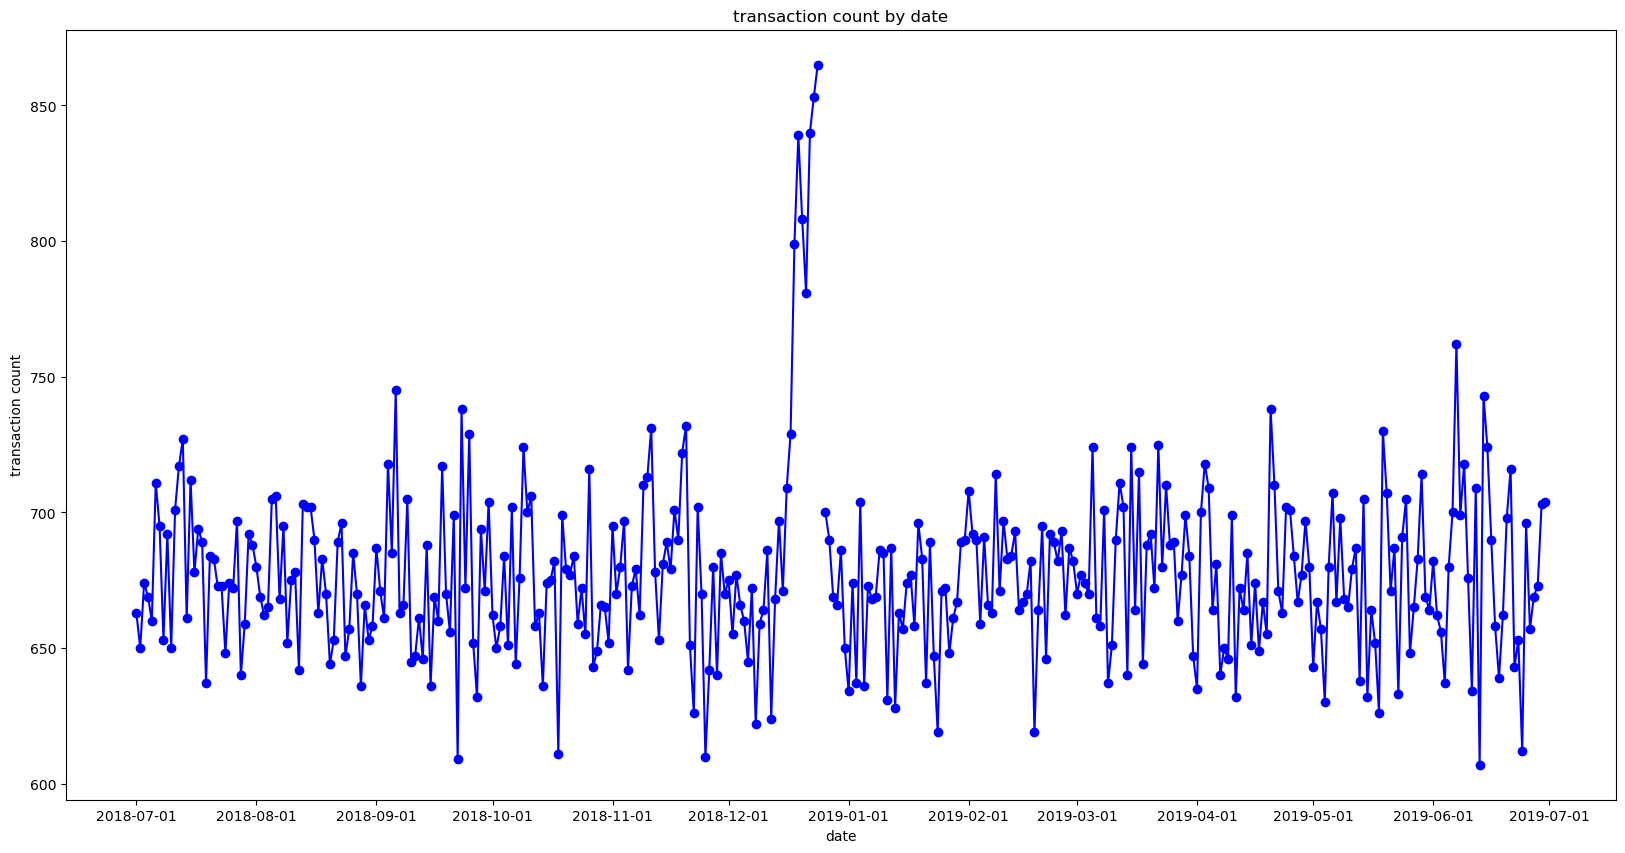

In [27]:
import matplotlib.dates as mdates
plt.figure(figsize=(20, 10))
plt.plot(merged_dates['DATE'], merged_dates['transaction count'], marker='o', color='blue')
plt.xlabel('date')
plt.ylabel('transaction count')
plt.title('transaction count by date')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.show()

As shown in the graph, there is a break in December, 2018 and also there is a incresement in December as well. Therefore, further anslysis is conducted for this month.

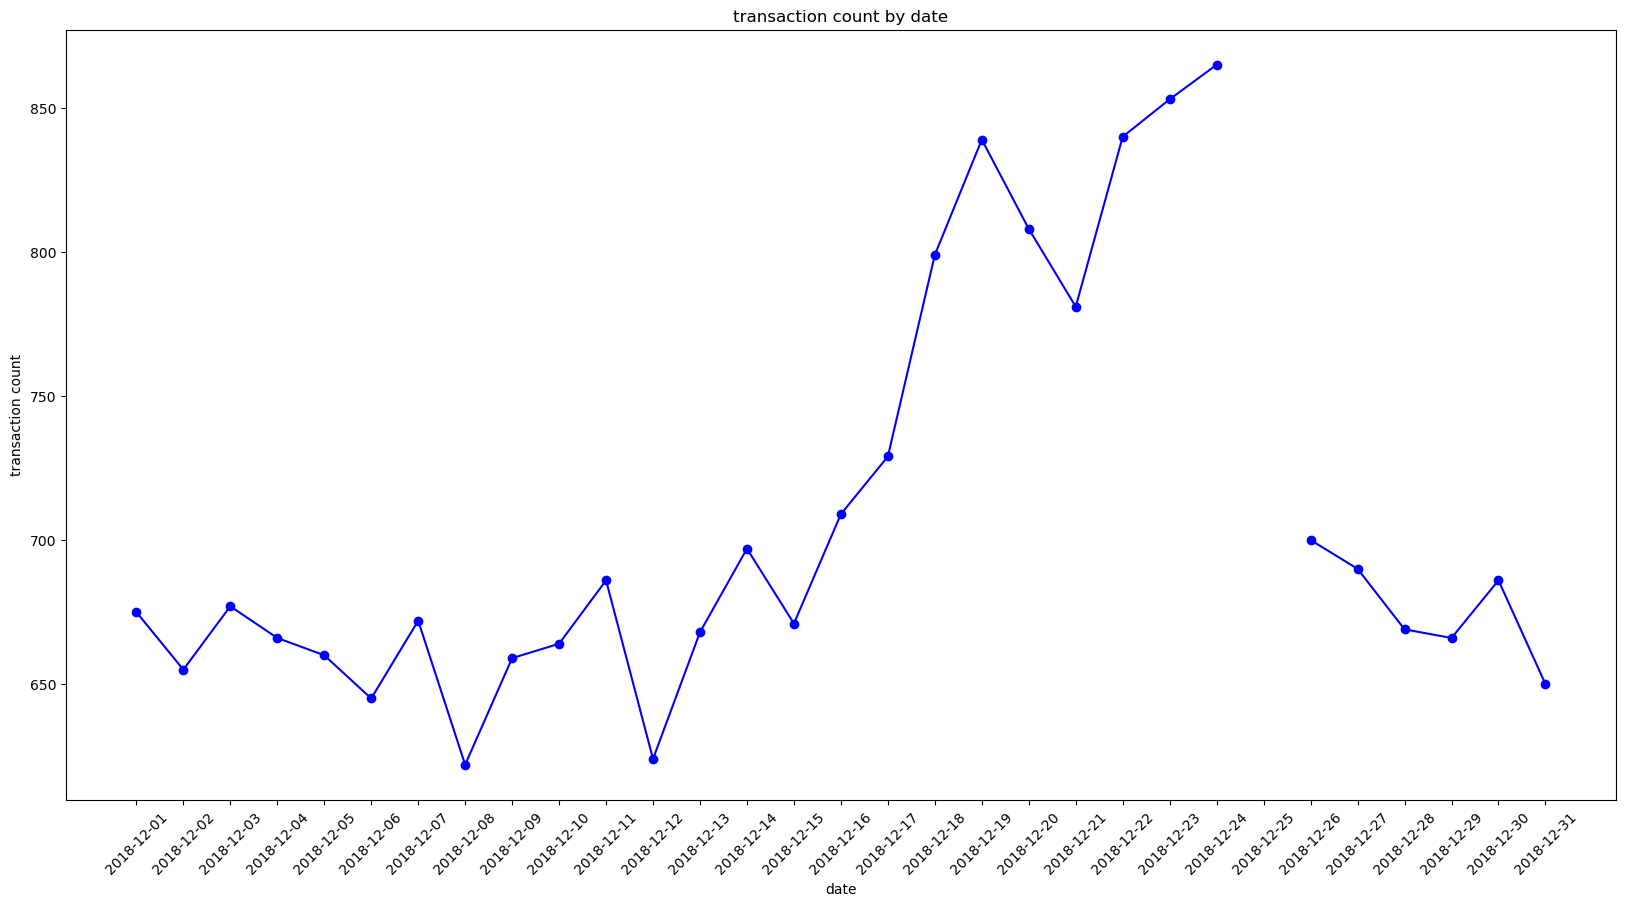

In [28]:
special_month = merged_dates.loc[(merged_dates['DATE'] >= '2018-12-01') & (merged_dates['DATE'] <= '2018-12-31')]
plt.figure(figsize=(20, 10))
plt.plot(special_month['DATE'], special_month['transaction count'], marker='o', color='blue')
plt.xlabel('date')
plt.ylabel('transaction count')
plt.title('transaction count by date')
plt.xticks(special_month['DATE'], rotation=45)
plt.show()

So, from the above plot, the sale boosted from 25/12 until 26/12 and the missing date is 2018-12-25, which is the Christmas Day. Hence, the missing data is resonable considering shops will be closed on this day.

Now that the observation of dates is done, the analysis shall move on to other features.

Check the packet size first

In [29]:
mean_size = transaction['PACK_SIZE'].mean()
min_size = transaction['PACK_SIZE'].min()
max_size = transaction['PACK_SIZE'].max()
print("Mean Packet Size:", mean_size)
print("Min Packet Size:", min_size)
print("Max Packet Size:", max_size)

Mean Packet Size: 175.5835211153441
Min Packet Size: 70
Max Packet Size: 380


The packet size seems reasonable. Next, move on to distribution of total transactions per packet size

In [30]:
packet_size_distribution = transaction.groupby('PACK_SIZE').size()
packet_size_distribution = pd.DataFrame(packet_size_distribution, columns=['transaction per packet size'])
packet_size_distribution

,transaction per packet size
PACK_SIZE,
70,1507
90,3008
110,22387
125,1454
134,25102
135,3257
150,40203
160,2970
165,15297


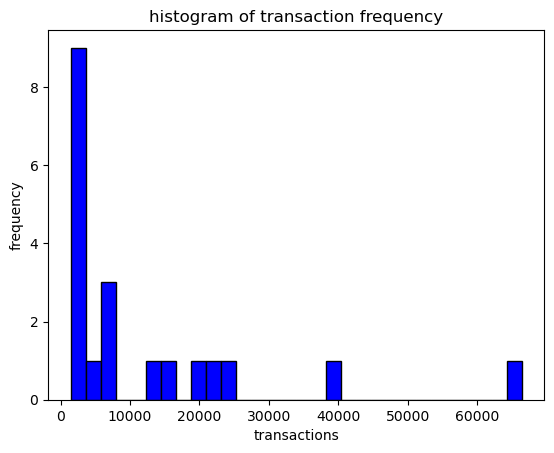

In [31]:
plt.hist(packet_size_distribution['transaction per packet size'], bins=30, color='blue', edgecolor='black')
plt.xlabel('transactions')
plt.ylabel('frequency')
plt.title('histogram of transaction frequency')
plt.show()

The distribution looks normal, move on to brand name

In [32]:
transaction['BRAND'] = transaction['PROD_TAG'].apply(lambda x: x[0])
brand_names = transaction['BRAND'].tolist()
brand_names = list(set(brand_names))
brand_names

C:\Users\lavel\AppData\Local\Temp\ipykernel_20428\3427409083.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transaction['BRAND'] = transaction['PROD_TAG'].apply(lambda x: x[0])


['Red',
 'Cobs',
 'Cheetos',
 'NCC',
 'Cheezels',
 'Grain',
 'Natural',
 'Pringles',
 'Twisties',
 'WW',
 'Tyrrells',
 'Smiths',
 'Sunbites',
 'French',
 'Infuzions',
 'RRD',
 'Woolworths',
 'GrnWves',
 'Snbts',
 'Infzns',
 'Kettle',
 'Burger',
 'Doritos',
 'Thins',
 'CCs',
 'Dorito',
 'Tostitos',
 'Smith']

In [33]:
transaction

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_TAG,PACK_SIZE,BRAND
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,"[Natural, Chip, Compny]",175,Natural
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,"[CCs, Nacho, Cheese]",175,CCs
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,"[Smiths, Crinkle, Cut, Chips, Chicken]",170,Smiths
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,"[Smiths, Chip, Thinly]",175,Smiths
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,"[Kettle, Tortilla, Chili]",150,Kettle
...,...,...,...,...,...,...,...,...,...,...,...
264831,2019-03-09,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,2,10.8,"[Kettle, Sweet, Chilli, And, Sour, Cream]",175,Kettle
264832,2018-08-13,272,272358,270154,74,Tostitos Splash Of Lime 175g,1,4.4,"[Tostitos, Splash, Of, Lime]",175,Tostitos
264833,2018-11-06,272,272379,270187,51,Doritos Mexicana 170g,2,8.8,"[Doritos, Mexicana]",170,Doritos
264834,2018-12-27,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8,"[Doritos, Corn, Chip, Mexican, Jalapeno]",150,Doritos


As shown above, there are some similar brand names such as: 'Smith', 'Smiths', 'Red' and 'RRD' and so on, to keep data simple and easy to read, these duplicated brand names can be unified and so does the associated transaction record

In [34]:
def brand_unification(string):
    if string == 'Smiths':
        return 'Smith'
    if string == 'Red':
        return 'RRD'
    if string == 'WW':
        return 'Woolworths'
    if string == 'Dorito':
        return 'Doritos'
    return string

In [35]:
transaction['BRAND'] = transaction['BRAND'].apply(brand_unification)
unified_brand_names = transaction['BRAND'].tolist()
unified_brand_names = list(set(unified_brand_names))
unified_brand_names

C:\Users\lavel\AppData\Local\Temp\ipykernel_20428\2532700633.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transaction['BRAND'] = transaction['BRAND'].apply(brand_unification)


['Cobs',
 'Cheetos',
 'NCC',
 'Cheezels',
 'Grain',
 'Natural',
 'Pringles',
 'Twisties',
 'Tyrrells',
 'Sunbites',
 'French',
 'Infuzions',
 'Woolworths',
 'RRD',
 'GrnWves',
 'Snbts',
 'Infzns',
 'Kettle',
 'Burger',
 'Doritos',
 'Thins',
 'CCs',
 'Tostitos',
 'Smith']

Now there are only unique brand names. 

Until now, the transaction data looks better, time to move on to customer data

2.Inspect the customer data

In [36]:
purchase_bhv = pd.read_csv('QVI_purchase_behaviour.csv')

Check if there is any row containing empty values

In [37]:
# return df boolean series where True represents a row containing empty value and False otherwise
rows_with_empty = purchase_bhv.isna().any(axis=1)
rows_with_empty = purchase_bhv[rows_with_empty]  # only keep rows contanining empty value
print(rows_with_empty.shape)

(0, 3)


According to the result, there is no empty value for this data set. Next step is to do format checking

In [38]:
print(purchase_bhv.dtypes)

LYLTY_CARD_NBR       int64
LIFESTAGE           object
PREMIUM_CUSTOMER    object
dtype: object


From the result, the majority of rows in each column are of data type: int, (object)string, (object)string. So, the next job is to check if all rows in each column share the same format.

In [39]:
rows_different_type = ~purchase_bhv['LYLTY_CARD_NBR'].apply(lambda x: isinstance(x, int))
print(rows_different_type)

0        False
1        False
2        False
3        False
4        False
         ...  
72632    False
72633    False
72634    False
72635    False
72636    False
Name: LYLTY_CARD_NBR, Length: 72637, dtype: bool


In [40]:
def is_uniform_format2(column_name, datatype):
    # return True if formats do not match
    rows_different_type = ~purchase_bhv[column_name].apply(lambda x: isinstance(x, datatype))  
    return rows_different_type.sum() == 0  # sum up all boolean values, if the sum is 0 then all boolean values are False

In [41]:
print(is_uniform_format2('LYLTY_CARD_NBR', int))
print(is_uniform_format2('LIFESTAGE', object))
print(is_uniform_format2('PREMIUM_CUSTOMER', object))

True
True
True


Based on the result, all values in each column are of same format

In the next step, I am going to aggregate value of same kinds and generate some informative graphs

Aggregate rows based on lifestage

In [42]:
lifestage = purchase_bhv.groupby('LIFESTAGE').size().reset_index(name='count')
lifestage

,LIFESTAGE,count
0,MIDAGE SINGLES/COUPLES,7275
1,NEW FAMILIES,2549
2,OLDER FAMILIES,9780
3,OLDER SINGLES/COUPLES,14609
4,RETIREES,14805
5,YOUNG FAMILIES,9178
6,YOUNG SINGLES/COUPLES,14441


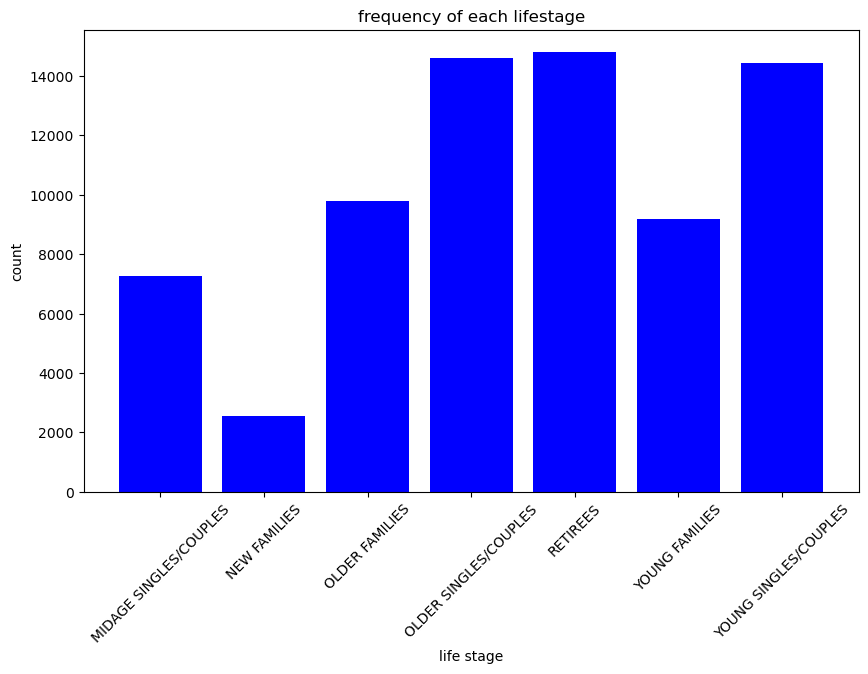

In [43]:
plt.figure(figsize=(10, 6))
plt.bar(lifestage['LIFESTAGE'], lifestage['count'], color='blue')
plt.xlabel('life stage')
plt.ylabel('count')
plt.title('frequency of each lifestage')
plt.xticks(rotation=45)
plt.show()

From the plot, it seems that more young and older people tend to spend on chips

Also, check about the distribution of customer segmentation

In [44]:
customer_seg = purchase_bhv.groupby('PREMIUM_CUSTOMER').size().reset_index(name='count')
customer_seg

,PREMIUM_CUSTOMER,count
0,Budget,24470
1,Mainstream,29245
2,Premium,18922


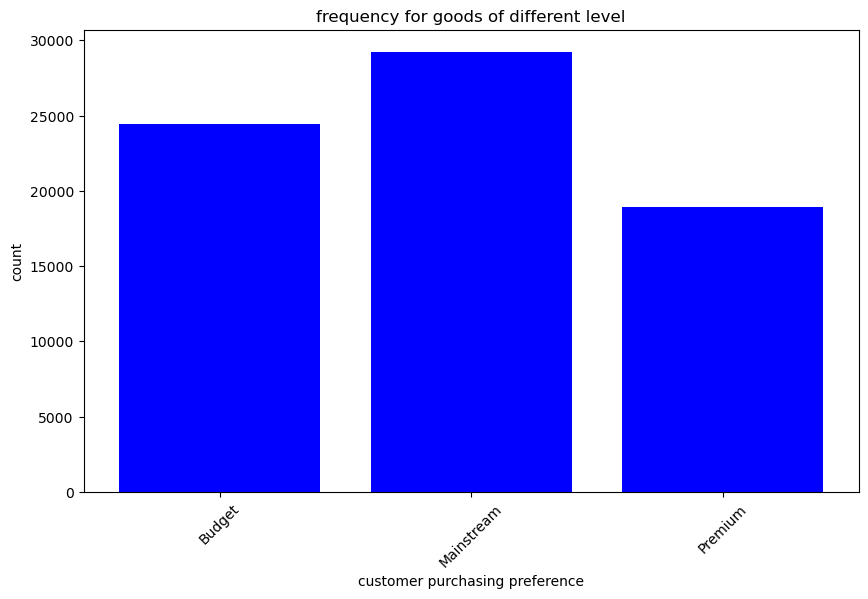

In [45]:
plt.figure(figsize=(10, 6))
plt.bar(customer_seg['PREMIUM_CUSTOMER'], customer_seg['count'], color='blue')
plt.xlabel('customer purchasing preference')
plt.ylabel('count')
plt.title('frequency for goods of different level')
plt.xticks(rotation=45)
plt.show()

This plot shows a normal dsitribution that more people tend to pursue the trend and save money on discounted producted, while relative less people would pay for premuim goods.

In [46]:
grouped_data = purchase_bhv.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).size().reset_index(name='occurence')
print(grouped_data)
print(grouped_data.shape)

                 LIFESTAGE PREMIUM_CUSTOMER  occurence
0   MIDAGE SINGLES/COUPLES           Budget       1504
1   MIDAGE SINGLES/COUPLES       Mainstream       3340
2   MIDAGE SINGLES/COUPLES          Premium       2431
3             NEW FAMILIES           Budget       1112
4             NEW FAMILIES       Mainstream        849
5             NEW FAMILIES          Premium        588
6           OLDER FAMILIES           Budget       4675
7           OLDER FAMILIES       Mainstream       2831
8           OLDER FAMILIES          Premium       2274
9    OLDER SINGLES/COUPLES           Budget       4929
10   OLDER SINGLES/COUPLES       Mainstream       4930
11   OLDER SINGLES/COUPLES          Premium       4750
12                RETIREES           Budget       4454
13                RETIREES       Mainstream       6479
14                RETIREES          Premium       3872
15          YOUNG FAMILIES           Budget       4017
16          YOUNG FAMILIES       Mainstream       2728
17        

<Figure size 2000x1000 with 0 Axes>

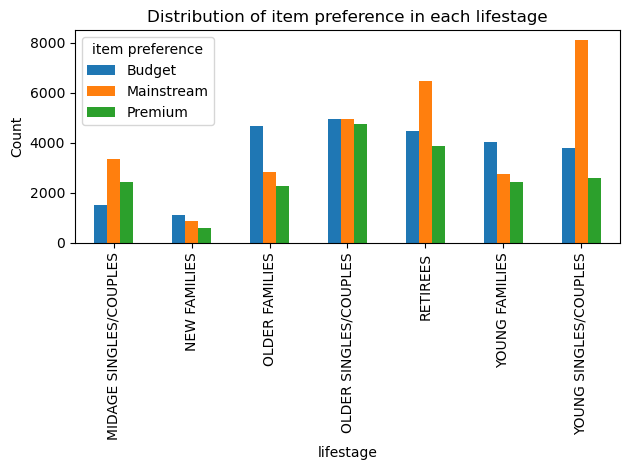

In [47]:
pivot_df = grouped_data.pivot(index='LIFESTAGE', columns='PREMIUM_CUSTOMER', values='occurence')
plt.figure(figsize=(20, 10))
pivot_df.plot(kind='bar', stacked=False)
plt.title('Distribution of item preference in each lifestage')
plt.xlabel('lifestage')
plt.ylabel('Count')
plt.legend(title='item preference')
plt.tight_layout()
plt.show()

Based on the former plot, we see that older families/singles/couples, retirees, young families/singles/couples tend to spend more products with discounts compared to midage singles/couples, new familes.

As for the brand effect, young singles/couples tend to be attracted by brands the most, followed by retirees, older single/couples. Also, a group of midage singles/couples, older families and young familes are selecting goods under the influence of brands as well, while new familes do not show affections for brands.

When it comes to quality stuff, older singles/couples and retirees tend to spend more on these things, and there is also a quantites of midage singles/couples, older families, young families and young singles/couples choose those items as well. Still, we can not see a bias on premium items for new families. 

Another thing to note is that from the above plot, it is obvious that there are more samples of young singles/couples while there are less of new familes, hence further data collecting and analysis need to be done to make correct conclusion about new families' preferences on items.

Merge two tables to get more information

In [48]:
merged_df = pd.merge(transaction, purchase_bhv, on='LYLTY_CARD_NBR', how='left')
merged_df

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_TAG,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,"[Natural, Chip, Compny]",175,Natural,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,"[CCs, Nacho, Cheese]",175,CCs,MIDAGE SINGLES/COUPLES,Budget
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,"[Smiths, Crinkle, Cut, Chips, Chicken]",170,Smith,MIDAGE SINGLES/COUPLES,Budget
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,"[Smiths, Chip, Thinly]",175,Smith,MIDAGE SINGLES/COUPLES,Budget
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,"[Kettle, Tortilla, Chili]",150,Kettle,MIDAGE SINGLES/COUPLES,Budget
...,...,...,...,...,...,...,...,...,...,...,...,...,...
246735,2019-03-09,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,2,10.8,"[Kettle, Sweet, Chilli, And, Sour, Cream]",175,Kettle,YOUNG SINGLES/COUPLES,Premium
246736,2018-08-13,272,272358,270154,74,Tostitos Splash Of Lime 175g,1,4.4,"[Tostitos, Splash, Of, Lime]",175,Tostitos,YOUNG SINGLES/COUPLES,Premium
246737,2018-11-06,272,272379,270187,51,Doritos Mexicana 170g,2,8.8,"[Doritos, Mexicana]",170,Doritos,YOUNG SINGLES/COUPLES,Premium
246738,2018-12-27,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8,"[Doritos, Corn, Chip, Mexican, Jalapeno]",150,Doritos,YOUNG SINGLES/COUPLES,Premium


check for empty values again to make sure that all customer have matched transaction data

In [49]:
rows_with_empty = merged_df.isna().any(axis=1)
rows_with_empty = merged_df[rows_with_empty]  # only keep rows contanining empty value
print(rows_with_empty.shape)

(0, 13)


From the result, there is no empty value, which implies that every transaction has a matched customer

In [50]:
merged_df.to_csv('QVI_data.csv', index=False)  # save the merged data into a csv file

3. Data analysis

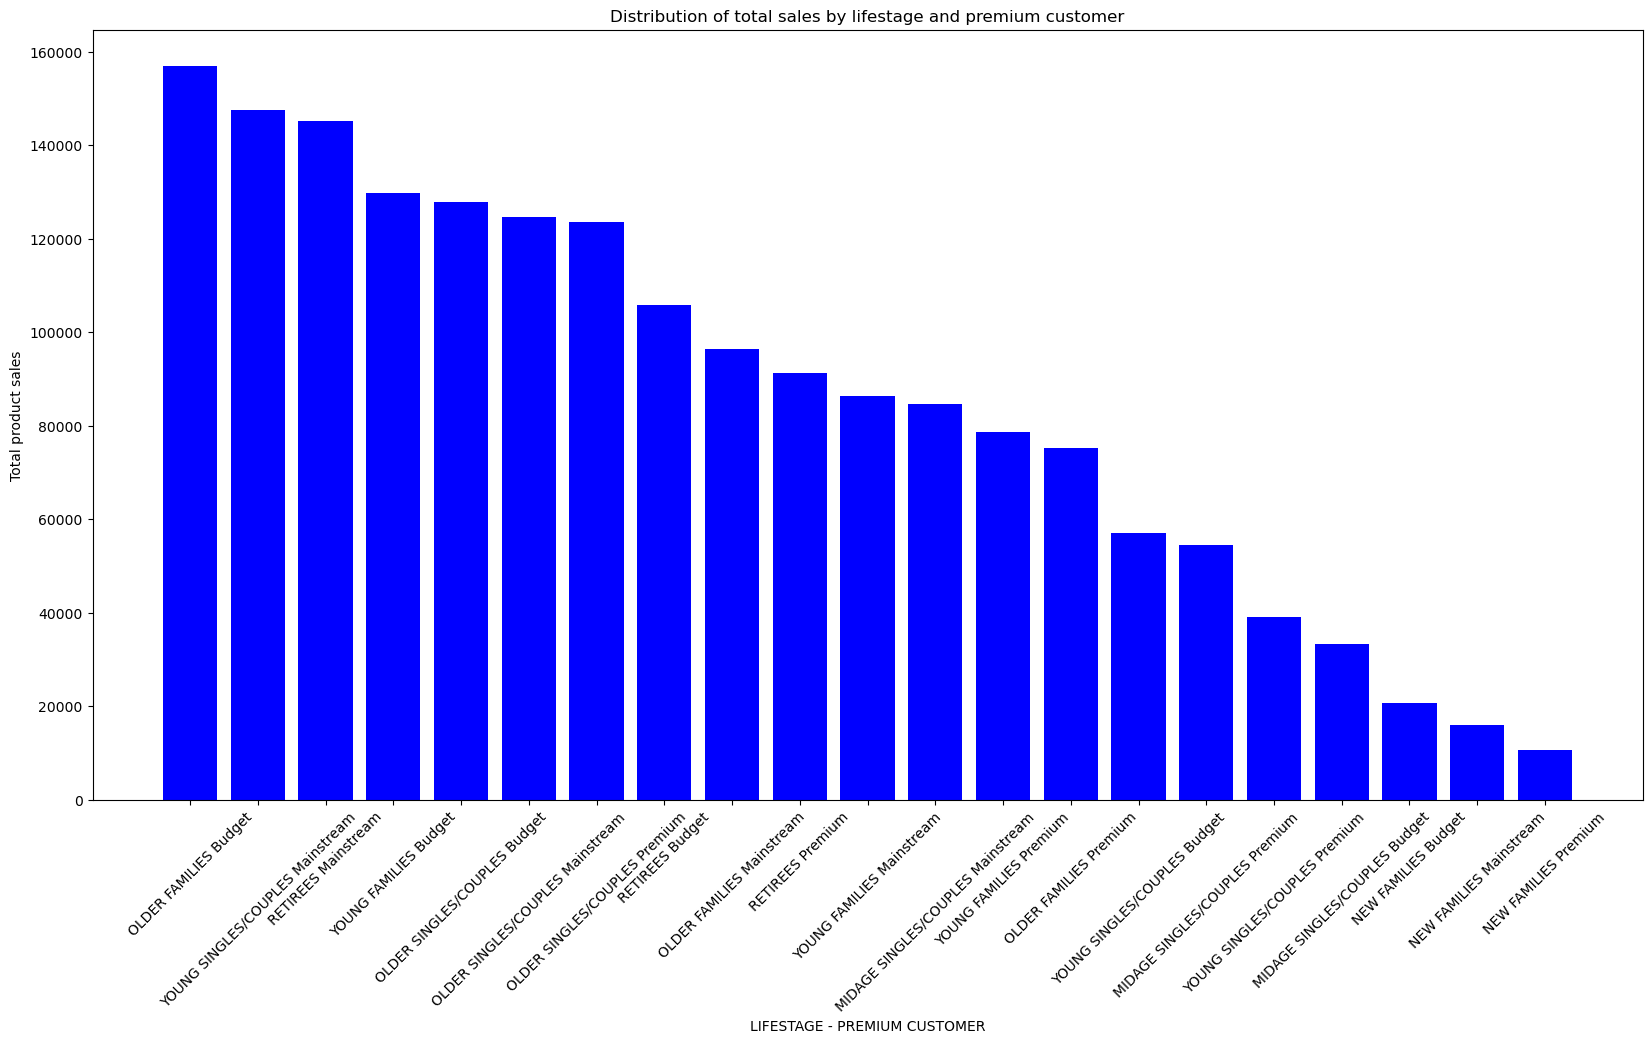

In [51]:
chip_sale = merged_df.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).TOT_SALES.sum().reset_index()
chip_sale = chip_sale.sort_values(by='TOT_SALES', ascending=False)
plt.figure(figsize=(20, 10))
plt.bar(chip_sale['LIFESTAGE'] + ' '+ chip_sale['PREMIUM_CUSTOMER'], chip_sale['TOT_SALES'], color='blue')
plt.xlabel('LIFESTAGE - PREMIUM CUSTOMER')
plt.ylabel('Total product sales')
plt.title('Distribution of total sales by lifestage and premium customer')
plt.xticks(rotation=45)
plt.show()

In [52]:
chip_sale

,LIFESTAGE,PREMIUM_CUSTOMER,TOT_SALES
6,OLDER FAMILIES,Budget,156863.75
19,YOUNG SINGLES/COUPLES,Mainstream,147582.20
13,RETIREES,Mainstream,145168.95
15,YOUNG FAMILIES,Budget,129717.95
9,OLDER SINGLES/COUPLES,Budget,127833.60
10,OLDER SINGLES/COUPLES,Mainstream,124648.50
11,OLDER SINGLES/COUPLES,Premium,123537.55
12,RETIREES,Budget,105916.30
7,OLDER FAMILIES,Mainstream,96413.55
14,RETIREES,Premium,91296.65


From the result, the main consumers are from older families / budget, young singles,couples/mainstream and retirees/ mainstream

Next step is to see if there is an association between the total sale and the quantity of customers.

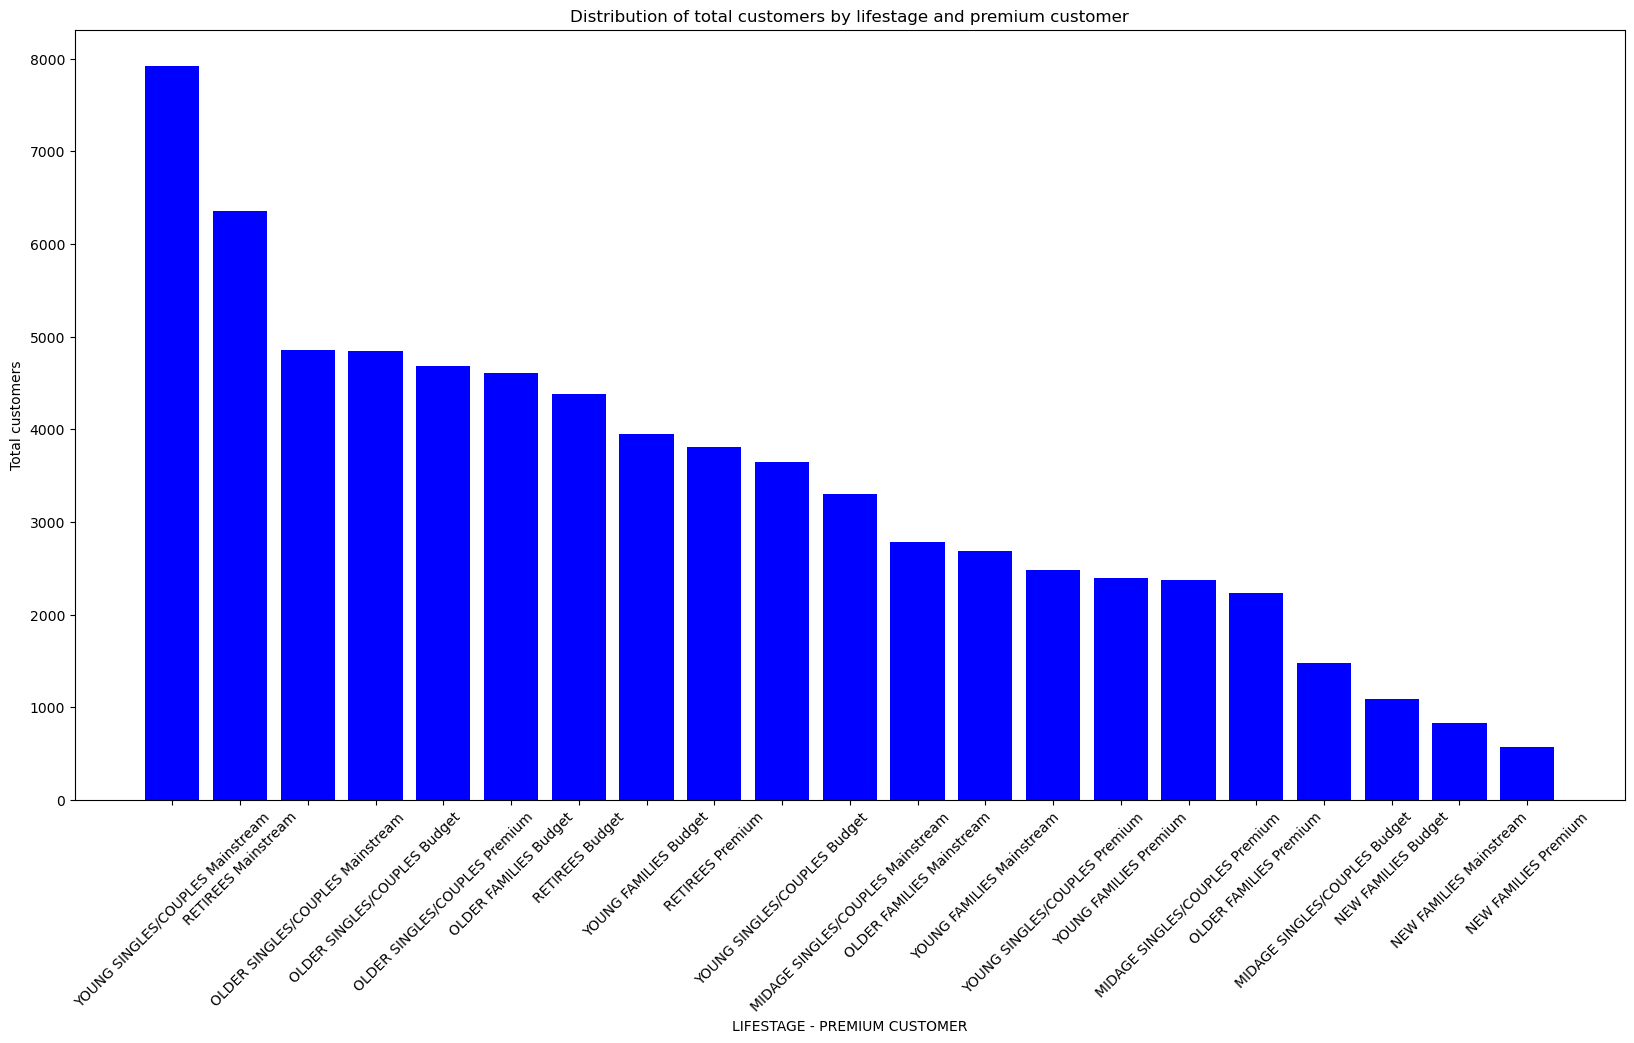

In [53]:
customer_distribution = merged_df.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['LYLTY_CARD_NBR'].nunique().reset_index(name='total_customers')
customer_distribution = customer_distribution.sort_values(by='total_customers', ascending=False)
plt.figure(figsize=(20, 10))
plt.bar(customer_distribution['LIFESTAGE'] + ' '+ customer_distribution['PREMIUM_CUSTOMER'], customer_distribution['total_customers'], color='blue')
plt.xlabel('LIFESTAGE - PREMIUM CUSTOMER')
plt.ylabel('Total customers')
plt.title('Distribution of total customers by lifestage and premium customer')
plt.xticks(rotation=45)
plt.show()

In [54]:
customer_distribution

,LIFESTAGE,PREMIUM_CUSTOMER,total_customers
19,YOUNG SINGLES/COUPLES,Mainstream,7917
13,RETIREES,Mainstream,6358
10,OLDER SINGLES/COUPLES,Mainstream,4858
9,OLDER SINGLES/COUPLES,Budget,4849
11,OLDER SINGLES/COUPLES,Premium,4682
6,OLDER FAMILIES,Budget,4611
12,RETIREES,Budget,4385
15,YOUNG FAMILIES,Budget,3953
14,RETIREES,Premium,3812
18,YOUNG SINGLES/COUPLES,Budget,3647


as can be seen, the main cusumers are young singles/couples mainstream and retirees mainstream, which can account for the fact of higer total sales, while it does not seem to be the main reason when it comes to older families budget.

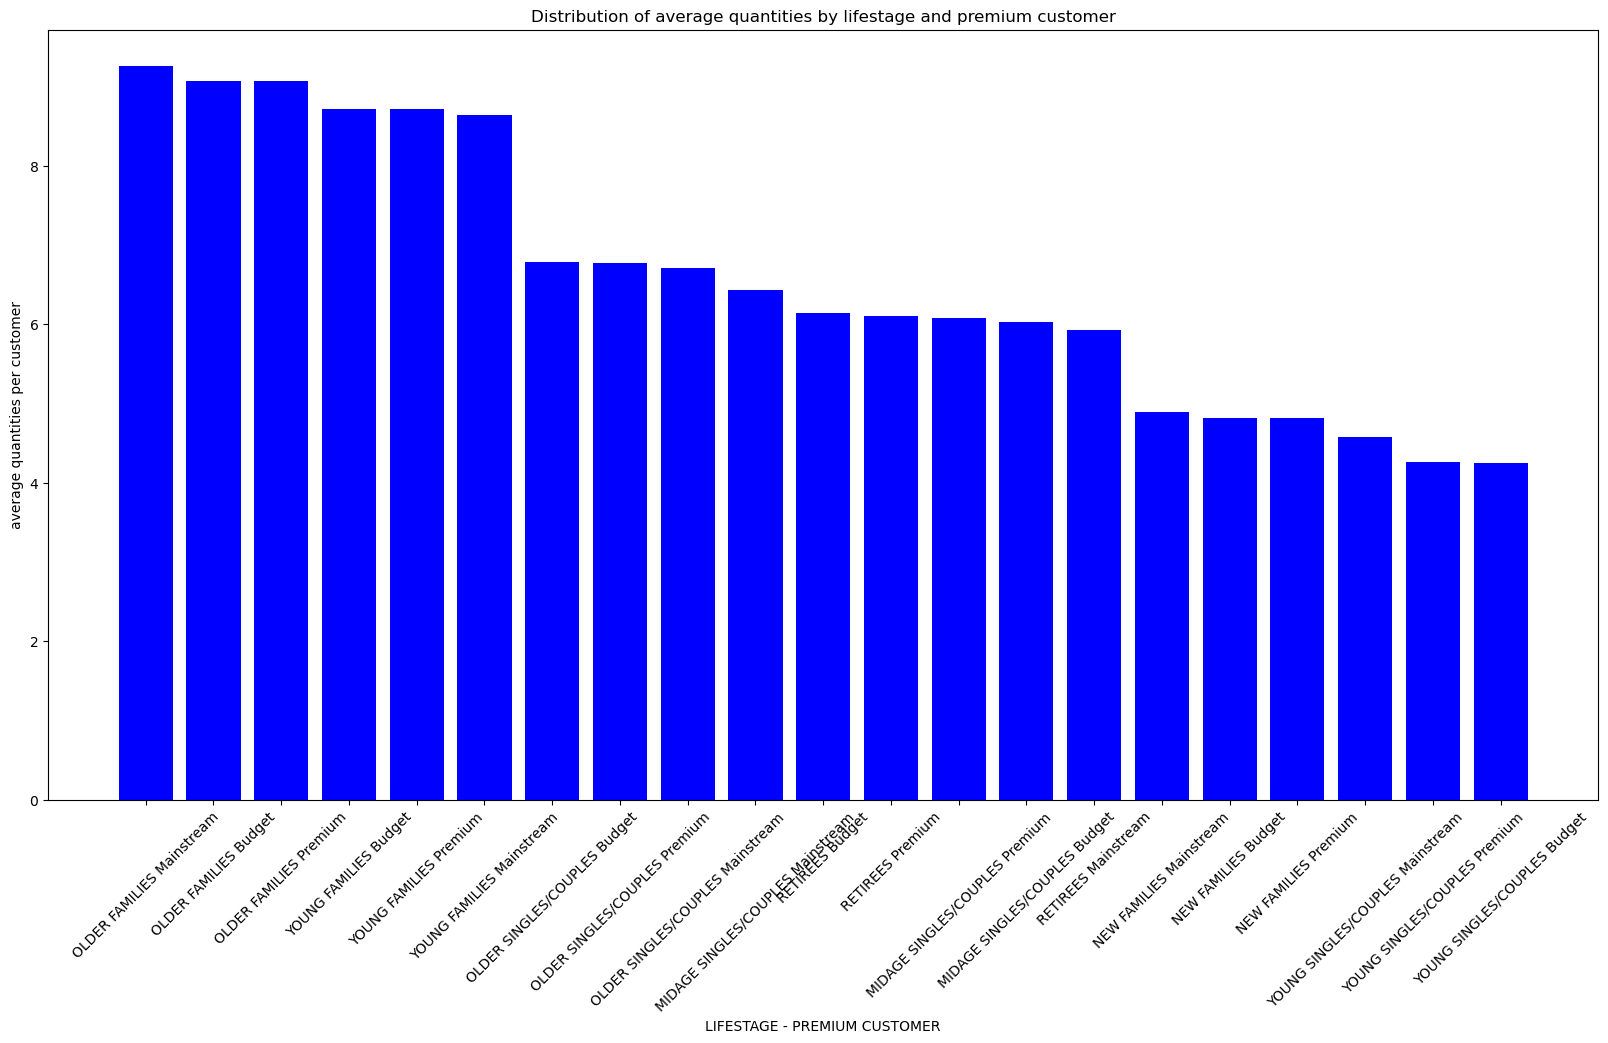

In [55]:
# get the total quantities per two dimensions
total_quantity = merged_df.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['PROD_QTY'].sum().reset_index(name='total_quantity')
# merge total quantity with total customers to calculate quantity per customer
merged_quantity = pd.merge(total_quantity, customer_distribution, on=['LIFESTAGE', 'PREMIUM_CUSTOMER'])
merged_quantity['avg_quantity_per_customer'] = merged_quantity['total_quantity'] / merged_quantity['total_customers']
merged_quantity = merged_quantity.sort_values(by='avg_quantity_per_customer', ascending=False)
plt.figure(figsize=(20, 10))
plt.bar(merged_quantity['LIFESTAGE'] + ' '+ merged_quantity['PREMIUM_CUSTOMER'], merged_quantity['avg_quantity_per_customer'], color='blue')
plt.xlabel('LIFESTAGE - PREMIUM CUSTOMER')
plt.ylabel('average quantities per customer')
plt.title('Distribution of average quantities by lifestage and premium customer')
plt.xticks(rotation=45)
plt.show()

In [56]:
merged_quantity

,LIFESTAGE,PREMIUM_CUSTOMER,total_quantity,total_customers,avg_quantity_per_customer
7,OLDER FAMILIES,Mainstream,25804,2788,9.255380
6,OLDER FAMILIES,Budget,41853,4611,9.076773
8,OLDER FAMILIES,Premium,20239,2231,9.071717
15,YOUNG FAMILIES,Budget,34482,3953,8.722995
17,YOUNG FAMILIES,Premium,20901,2398,8.716013
16,YOUNG FAMILIES,Mainstream,23194,2685,8.638361
9,OLDER SINGLES/COUPLES,Budget,32883,4849,6.781398
11,OLDER SINGLES/COUPLES,Premium,31695,4682,6.769543
10,OLDER SINGLES/COUPLES,Mainstream,32607,4858,6.712021
1,MIDAGE SINGLES/COUPLES,Mainstream,21213,3298,6.432080


Based on the result, older families and young families tend to purchase more chips on average.

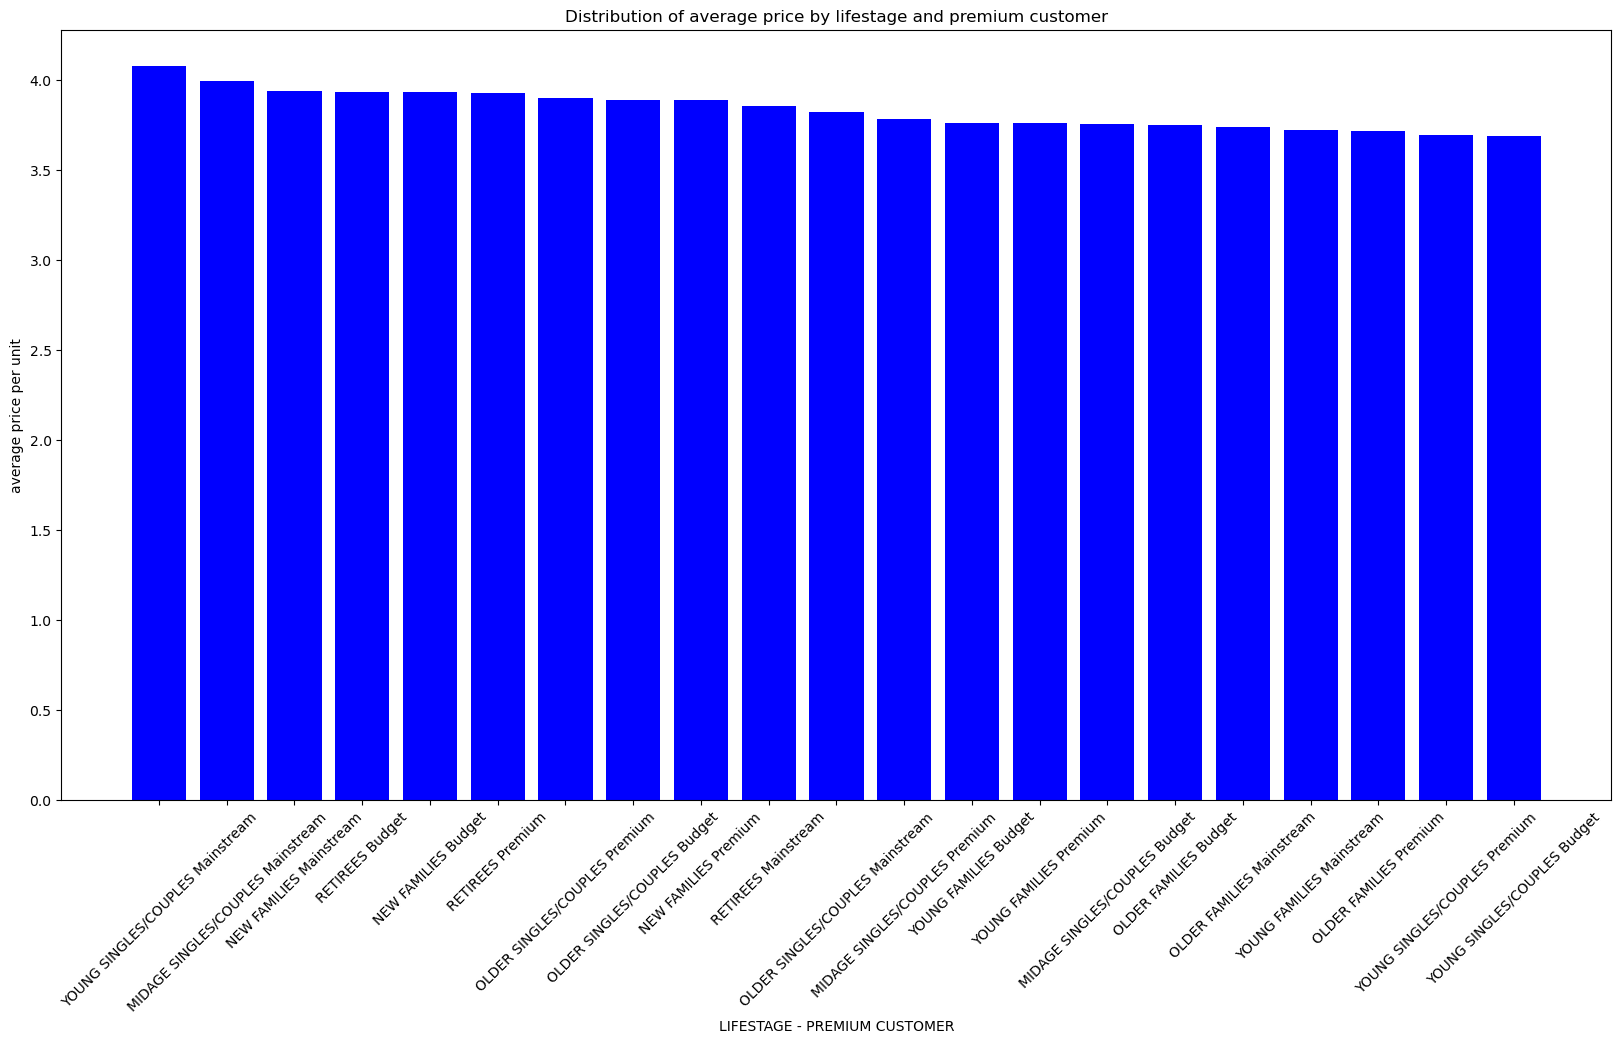

In [57]:
# merge total price and total quantity to get average price per quantity
merged_quantity = pd.merge(total_quantity, chip_sale, on=['LIFESTAGE', 'PREMIUM_CUSTOMER'])
merged_quantity['avg_price_per_unit'] = merged_quantity['TOT_SALES'] / merged_quantity['total_quantity']
merged_quantity = merged_quantity.sort_values(by='avg_price_per_unit', ascending=False)
plt.figure(figsize=(20, 10))
plt.bar(merged_quantity['LIFESTAGE'] + ' '+ merged_quantity['PREMIUM_CUSTOMER'], merged_quantity['avg_price_per_unit'], color='blue')
plt.xlabel('LIFESTAGE - PREMIUM CUSTOMER')
plt.ylabel('average price per unit')
plt.title('Distribution of average price by lifestage and premium customer')
plt.xticks(rotation=45)
plt.show()

In [58]:
merged_quantity

,LIFESTAGE,PREMIUM_CUSTOMER,total_quantity,TOT_SALES,avg_price_per_unit
19,YOUNG SINGLES/COUPLES,Mainstream,36225,147582.20,4.074043
1,MIDAGE SINGLES/COUPLES,Mainstream,21213,84734.25,3.994449
4,NEW FAMILIES,Mainstream,4060,15979.70,3.935887
12,RETIREES,Budget,26932,105916.30,3.932731
3,NEW FAMILIES,Budget,5241,20607.45,3.931969
14,RETIREES,Premium,23266,91296.65,3.924037
11,OLDER SINGLES/COUPLES,Premium,31695,123537.55,3.897698
9,OLDER SINGLES/COUPLES,Budget,32883,127833.60,3.887529
5,NEW FAMILIES,Premium,2769,10760.80,3.886168
13,RETIREES,Mainstream,37677,145168.95,3.852986


As the result indicates, young single/couples mainstream and midage single/couple mainstream are more willing to spend more on chips compared to their premium counterpart.

Also, we can see that the average price variance is not huge, so by performing a t-test, whether or not the statistical difference is significant can be confirmed. Hence, next step is performing t-test on midage singles/couples and young singles/couples.

In [84]:
# filter out rows with only midage singles/couples and young singles/couples respectively
merged_df['average price per unit'] = merged_df['TOT_SALES'] / merged_df['PROD_QTY']
midage_mainstream = c['average price per unit']
midage_budget = merged_df[(merged_df['PREMIUM_CUSTOMER'] == 'Budget') & (merged_df['LIFESTAGE'] == 'MIDAGE SINGLES/COUPLES')]['average price per unit']
midage_premium = merged_df[(merged_df['PREMIUM_CUSTOMER'] == 'Premium') & (merged_df['LIFESTAGE'] == 'MIDAGE SINGLES/COUPLES')]['average price per unit']
young_mainstream = merged_df[(merged_df['PREMIUM_CUSTOMER'] == 'Mainstream') & (merged_df['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES')]['average price per unit']
young_budget = merged_df[(merged_df['PREMIUM_CUSTOMER'] == 'Budget') & (merged_df['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES')]['average price per unit']
young_premium = merged_df[(merged_df['PREMIUM_CUSTOMER'] == 'Premium') & (merged_df['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES')]['average price per unit']

In [86]:
import scipy.stats as stats
# t-test on midage
t_statistic, p_value_mmb = stats.ttest_ind(midage_mainstream, midage_budget)
print("Mainstream vs Budget: t-statistic = {}, p-value = {}".format(t_statistic, p_value_mmb))

t_statistic, p_value_mmp = stats.ttest_ind(midage_mainstream, midage_premium)
print("Mainstream vs Budget: t-statistic = {}, p-value = {}".format(t_statistic, p_value_mmp))

Mainstream vs Budget: t-statistic = 13.751072106888365, p-value = 8.853602155660751e-43
Mainstream vs Budget: t-statistic = 14.213565363736198, p-value = 1.3043340153614925e-45


Since the p-value of mainstream and budget as well as mainstream and premium is significantly smaller than 0.05, it can be concluded that there are statistically significant differences on unit price between mainstream midage singles/couples and its counterparts 

In [87]:
# t-test on young group
t_statistic, p_value_ymb = stats.ttest_ind(young_mainstream, young_budget)
print("Mainstream vs Budget: t-statistic = {}, p-value = {}".format(t_statistic, p_value_ymb))

t_statistic, p_value_ymp = stats.ttest_ind(young_mainstream, young_premium)
print("Mainstream vs Budget: t-statistic = {}, p-value = {}".format(t_statistic, p_value_ymp))

Mainstream vs Budget: t-statistic = 30.589098703099964, p-value = 3.52971264473368e-202
Mainstream vs Budget: t-statistic = 26.176571895308655, p-value = 4.667997920183129e-149


Based on the result, there are also significant statistical differences on unit price between mainstream young singles/couples compared to its counterparts.

Also, since young single/couples mainstream are prone to spend more on chips, further investigation could be done for this specific group

In [88]:
main_young_sg_cp = merged_df[(merged_df['PREMIUM_CUSTOMER'] == 'Mainstream') & (merged_df['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES')]
main_young_sg_cp

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_TAG,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,average price per unit
221345,2018-08-16,1,1020,26,19,Smiths Crinkle Cut Snag&Sauce 150g,1,2.6,"[Smiths, Crinkle, Cut]",150,Smith,YOUNG SINGLES/COUPLES,Mainstream,2.6
221346,2018-08-17,1,1163,188,46,Kettle Original 175g,1,5.4,"[Kettle, Original]",175,Kettle,YOUNG SINGLES/COUPLES,Mainstream,5.4
221347,2018-08-14,1,1291,333,27,WW Supreme Cheese Corn Chips 200g,1,1.9,"[WW, Supreme, Cheese, Corn, Chips]",200,Woolworths,YOUNG SINGLES/COUPLES,Mainstream,1.9
221348,2019-05-15,3,3031,1227,14,Smiths Crnkle Chip Orgnl Big Bag 380g,1,5.9,"[Smiths, Crnkle, Chip, Orgnl, Big, Bag]",380,Smith,YOUNG SINGLES/COUPLES,Mainstream,5.9
221349,2019-05-18,3,3118,1574,62,Pringles Mystery Flavour 134g,1,3.7,"[Pringles, Mystery, Flavour]",134,Pringles,YOUNG SINGLES/COUPLES,Mainstream,3.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240884,2018-12-01,272,272377,270186,75,Cobs Popd Sea Salt Chips 110g,2,7.6,"[Cobs, Popd, Sea, Salt, Chips]",110,Cobs,YOUNG SINGLES/COUPLES,Mainstream,3.8
240885,2018-07-27,272,272389,270200,114,Kettle Sensations Siracha Lime 150g,2,9.2,"[Kettle, Sensations, Siracha, Lime]",150,Kettle,YOUNG SINGLES/COUPLES,Mainstream,4.6
240886,2018-11-10,272,272389,270201,26,Pringles Sweet&Spcy BBQ 134g,2,7.4,"[Pringles, BBQ]",134,Pringles,YOUNG SINGLES/COUPLES,Mainstream,3.7
240887,2019-04-01,272,272389,270202,62,Pringles Mystery Flavour 134g,2,7.4,"[Pringles, Mystery, Flavour]",134,Pringles,YOUNG SINGLES/COUPLES,Mainstream,3.7


take a look at the group's favourite chip brands

In [92]:
fav_brands = main_young_sg_cp.groupby('BRAND').size().reset_index(name='brand count')
fav_brands = fav_brands.sort_values(by='brand count', ascending=False)
fav_brands

,BRAND,brand count
11,Kettle,3844
5,Doritos,2379
14,Pringles,2315
16,Smith,1921
19,Thins,1166
9,Infuzions,962
21,Twisties,900
20,Tostitos,890
15,RRD,875
4,Cobs,864


As is shown above, the top 3 favoured chip brands are Kettle, Doritos and Pringles.

In [93]:
fav_size = main_young_sg_cp.groupby('PACK_SIZE').size().reset_index(name='size count')
fav_size = fav_size.sort_values(by='size count', ascending=False)
fav_size

,PACK_SIZE,size count
10,175,4997
6,150,3080
4,134,2315
2,110,2051
9,170,1575
18,330,1195
8,165,1102
19,380,626
17,270,620
14,210,576


In [94]:
mean_size = fav_size['PACK_SIZE'].mean()
min_size = fav_size['PACK_SIZE'].min()
max_size = fav_size['PACK_SIZE'].max()
print("Mean Packet Size:", mean_size)
print("Min Packet Size:", min_size)
print("Max Packet Size:", max_size)

Mean Packet Size: 185.7
Min Packet Size: 70
Max Packet Size: 380


As per the result, the target group does not seem to be particularly intersted in buying chips of larger size, instead they seem to prefer medium sized chips.